# Investigating Submarine Groundwater Discharge using Sea-Surface Temperature and K-Means Clustering

## Introduction & Description of Problem

Submarine Groundwater Discharge (SGD) is a major flux of terrestrial water to the ocean, and plays an important role in several processes. A large flux of nutrients is transported in the dissolved load of SGD, typically greater than the flux from rivers (Santos et al. 2021), influencing seawater biodiversity. This process is also affected by anthropogenic activities, with excess nutrient runoff from fertlizers causing eutrophicatin (D'Elia et al., 1981). The relative freshness of SGD compared to seawater also makes it ideal for desalination and human consumption where other sources of freshwater are not as readily available (Post et al., 2013).

Despite the importance of SGD, its occurance and behaviour has been poorly undrestood, and historically researchers have relied on in-situ measurements and modeling (Burnett et al., 2006). In recent decades, remote sensing has provided an enormous source of data with the potential for large scale observation of SGD. The data from the Landsat-5, 7 and 8 missions have proven especially popular among researchers. Machine learning algorithms such as K-means and Gaussian Mixture Models can aid in extracting results from the large datasets produced by these satelite missions.

One recent such study by Caineta et al. (2022) utilizes data from Landsat-7 and 8 to study SGD plumes off the coast of southern Ireland and Hawaii. They look at several variables including sea surface temperature (SST, using surface radiance in the infrared range) and seawater colour (utilizing radiance in the visual to near infrared range). SST values are clustered using a K-means algorithm, and the warmest two clusters are used to help identify SGD. By combining their observations of SST and color the authors identify potential SGD and confirm this with reliable in-situ measurements.

This final project for GEOL0069 is inspired by this paper, but to remain within the scope of this project, I have restricted myself to a single location, using only Landsat-7 data, and just SST classification. The goal is to use a K-means algorithm called ckmeans-1d-dp to seperate SST pixels into clusters based on temperature, preparing the data to be used in a larger process such as by Caineta et al.. ckmeans-1d-dp is a K-means algorithm optimised for univariate datasets, such as SST (Wang and Song, 2011). Like other K-means algorithms, it works by minimising within-class variance while maximizing between-class variance.



## Steps Taken

### 1. Obtaining Data

The remotely sensed data for this project was sourced from the Landsat-7 Mission. The Enhanced Thematic Mapper Plus (ETM+) instrument on board the satelite contained a thermal infrared channel that was a four-fold improvement on previous itterations and contained 8 different spectral bands. The most important here is the thermal band, that produced infra-red radiance measurements of the earth surface and can be used to calculate sea surface temperature. This band produced data with a 60m spatial resolution and is available as low- and high-gain products. We use the high-gain product as it has a higher sensitivity.

The bands 3 and 4 detect red and near infra-red light levels respectively, and were used to create land masks to focus just on SST (more later). These were available at 30m resolution. Additionally, DEM data from the Shuttle Radar Topography Mission (SRTM) was also obtained to be used for the land mask. This will also be explained later. All data was obtained through the USGS EarthExplorer interface.

The Landsat-7 satelite collected data until January 19, 2024. Most of our data is from 2023. Unfortunately, this means that the data has some slight gaps in it, due to the failure of the Scan Line Corrector (SLC) in 2003. The effects are illustrated in the images below and is seen in our results:

![slc.jpg](images/with-without-SLC.jpg)

![slc2.jpg](images/slc.jpeg)



### 2. Calculating Sea Surface Temperature from Radiance

The first step for this was calibrating using the MTL metadata file associated with our Landsat-7 data. This involves parsing the MTL file to automatically find the values of maximum radiance and certain quantiles. We then convert from radiance to temperature (in Kelvin) using the following formulae:

$$
L_\lambda = \frac{(L_{\text{MAX}} - L_{\text{MIN}})}{(Q_{\text{CALMAX}} - Q_{\text{CALMIN}})} \cdot (Q_{\text{CAL}} - Q_{\text{CALMIN}}) + L_{\text{MIN}}
$$

$$
T = \frac{K_2}{\ln\left(\frac{K_1}{L_\lambda} + 1\right)}
$$

\begin{aligned}
Where: \\
L_\lambda & = \text{Spectral radiance at the sensor's aperture (W/(m}^2\cdot\text{sr}\cdot\mu\text{m))} \\
Q_{\text{CAL}} & = \text{Quantized calibrated pixel value (digital number, DN)} \\
L_{\text{MAX}}, L_{\text{MIN}} & = \text{Spectral radiance scales (max/min) for the band} \\
Q_{\text{CALMAX}}, Q_{\text{CALMIN}} & = \text{Maximum and minimum quantized calibrated values (usually 255 and 1)} \\
K_1, K_2 & = \text{Calibration constants for thermal conversion (from MTL file)} \\
T & = \text{brightness temperature (Kelvin)} \\
\end{aligned}


This is then converted to degrees Celcius, and plotted as Figure 1

### 3. Creating a Mask for Land

For SGD applications we are only interested in sea surface temperature, and as such the land surface temperature can result in skewed results as the land is typically much warmer than the sea. Therefore we need to find a way to create a water mask that allows us only to take water temperatures into account. To achieve this we use two methods. First, by using the red and infrared bands of Landsat 7, we can use the Normalised Difference Vegetation Index (NDVI) to differentiate between land and sea, where water is disinguished by NDVI values below -0.05. The following equation is used to calculate NDVI:


$$
\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}
$$

Where:
- **NIR** is the reflectance in the near-infrared band
- **RED** is the reflectance in the red band


Additionally, a DEM can be created of the land and nearby sea, where elevation under 5 meters was considered to be ocean.

We also make the assumption that seawater temperatures will not exceed 35 degrees celcius. Along with this assumption and the DEM and NDVI masks we create a water mask, allowing us to focus on only SST.

A more interesting solution to this is to apply an unsupervised (or better yet, supervised) learning method to differentiate between land and sea. To stay within the scope of this project this was not performed.

### 4. Implementing K-Means Clustering
 
K-Means clustering is an unsupervised learning method, meaning its training data is not labelled (differentiating it from supervised learning methods). It is centroid based, and in this case the centroids are the mean value of each cluster. The algorithm works by maximising the distance between centroids, while minimizing the variance within the cluster associated with each centroid. One of the key metrics for this is the sum of squared errors, which represents variance within a dataset and is minimized by the algorithm. K-means is scaleable, fast and easy to understand machine learning method, which has made it one of the most popular. On the other hand, the method is sensitive to outliers, which is why the higher land temperatures in our area are masked.

We go a step further by choosing the ckmeans-1d-dp algorithm for this project. This algorithm is optmized for univariate (1-dimensional) applications, such as SST. Regular K-means applications, such as through the scikit-learn package are optimised for higher dimensional data. It originated with the ckmeans.1d.dp algorithm written for the R programming language (Wand and Song, 2011). Here we use a python interface ckmeans-1d-dp.

### 5. Plotting Results

The final step is to plot our results. First all five bands are plotted, then a seperate plot shows us the two warmest bands. These SST 'anomalies' are typically used alongside data of sea surface colour (indicating photosynthesis and therefore higher nutrient fluxes through groundwater). Together they can indicate potential subsurface groundwater discharge.

## Python Script

In [104]:
# 1. Installing Dependencies
%pip install rasterio numpy matplotlib ckmeans-1d-dp

Note: you may need to restart the kernel to use updated packages.


In [105]:
### 0. Import necessary packages

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ckmeans_1d_dp import ckmeans
import re
import os
import glob

### 1. Include all file paths
tiff_path = '../data/2010-06-02/LE07_L1TP_206024_20100602_20200911_02_T1_B6_VCID_2.TIF' # Landsat 7 (L7) Band 6 high gain file
red_band_path = "../data/2010-06-02/LE07_L1TP_206024_20100602_20200911_02_T1_B3.TIF" # L7 Band 3 file
nir_band_path = "../data/2010-06-02/LE07_L1TP_206024_20100602_20200911_02_T1_B4.TIF" # L7 Band 4 file
mtl_path = "../data/2010-06-02/LE07_L1TP_206024_20100602_20200911_02_T1_MTL.txt" # L7 metadata file
dem_folder = '../data/dem_tiles'  # Folder of DEM tiles covering the L7 tile
output_merged_dem = '../data/merged_dems/merged_srtm.tif' # output DEM 
output_dem_path = '../data/merged_dems/srtm_reprojected.tif'  # Output DEM reprojected/resampled to match Landsat
output_dir = "../data/final_plots" # Filepath for final plots
os.makedirs(output_dir, exist_ok=True)

### 2. Parse L7 metadata to calibrate for calculation of SST from infrared radiance
def parse_mtl(path):
    with open(path, 'r') as f:
        mtl_data = f.read()
    metadata = {}
    keys = {
        "LMAX": "RADIANCE_MAXIMUM_BAND_6_VCID_2",
        "LMIN": "RADIANCE_MINIMUM_BAND_6_VCID_2",
        "QCALMAX": "QUANTIZE_CAL_MAX_BAND_6_VCID_2",
        "QCALMIN": "QUANTIZE_CAL_MIN_BAND_6_VCID_2",
        "K1": "K1_CONSTANT_BAND_6_VCID_2",
        "K2": "K2_CONSTANT_BAND_6_VCID_2"
    }
    for key, mtl_key in keys.items():
        match = re.search(f"{mtl_key}\s=\s([0-9\.]+)", mtl_data)
        if match:
            metadata[key] = float(match.group(1))
        else:
            raise ValueError(f"{mtl_key} not found in MTL file.")
    return metadata

params = parse_mtl(mtl_path)
LMAX = params["LMAX"]
LMIN = params["LMIN"]
QCALMAX = params["QCALMAX"]
QCALMIN = params["QCALMIN"]
K1 = params["K1"]
K2 = params["K2"]

### 3. Load L7 radiance data
with rasterio.open(tiff_path) as src:
    dn = src.read(1).astype(float)
    profile = src.profile

dn[dn <= QCALMIN] = np.nan

<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
/var/folders/h_/7vbz_661085_0zlkpxz6pf0m0000gn/T/ipykernel_56186/833769169.py:40: SyntaxWarning: invalid escape sequence '\s'
  match = re.search(f"{mtl_key}\s=\s([0-9\.]+)", mtl_data)


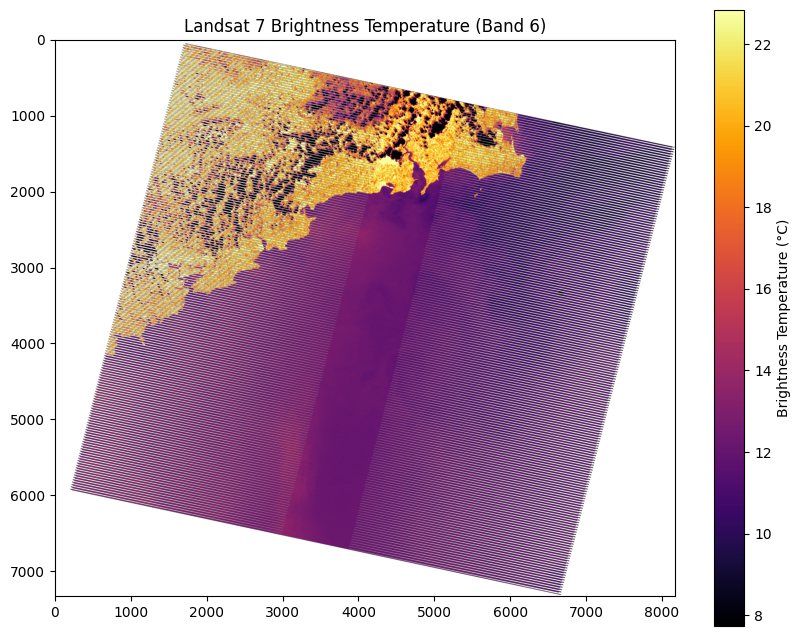

Figure 1: Brightness temperature plot saved as: ../data/final_plots/bt_celsius_plot.png


In [106]:
### 4. convert from radiance to temperature (in degrees celcius)
radiance = ((LMAX - LMIN) / (QCALMAX - QCALMIN)) * (dn - QCALMIN) + LMIN
bt_kelvin = K2 / np.log((K1 / radiance) + 1)
bt_celsius = bt_kelvin - 273.15

# Plot Brightness Temperature (bt_celsius)
plt.figure(figsize=(10, 8))
vmin, vmax = np.nanpercentile(bt_celsius, [2, 98])  # for good contrast; adjust if needed
im = plt.imshow(bt_celsius, cmap="inferno", vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label("Brightness Temperature (°C)")
plt.title("Landsat 7 Brightness Temperature (Band 6)")
bt_plot_path = os.path.join(output_dir, "bt_celsius_plot.png")
plt.savefig(bt_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 1: Brightness temperature plot saved as: {bt_plot_path}")

In [107]:
### 5. Prepare and implement 'water mask' to ignore land temperatures
## 5.1. loading red and NIR bands to use NDVI to distinguish water from land
with rasterio.open(red_band_path) as red_src:
    red = red_src.read(1).astype(float)

with rasterio.open(nir_band_path) as nir_src:
    nir = nir_src.read(1).astype(float)

ndvi = (nir - red) / (nir + red + 1e-6)

## 5.2. Combining and reprojecting DEMs to create mask based on elevation

dem_files = glob.glob(os.path.join(dem_folder, '*.tif'))
src_files_to_mosaic = [rasterio.open(fp) for fp in dem_files]

# 5.2.1. Merging DEMs
mosaic, out_transform = merge(src_files_to_mosaic)

out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform,
    "count": 1
})

with rasterio.open(output_merged_dem, "w", **out_meta) as dest:
    dest.write(mosaic[0], 1)

for src in src_files_to_mosaic:
    src.close()

print(f"Merged DEM saved as: {output_merged_dem}")

# 5.2.2. Reprojecting DEMs to match Landsat data

with rasterio.open(tiff_path) as landsat:
    dst_crs = landsat.crs
    dst_transform = landsat.transform
    dst_shape = (landsat.height, landsat.width)
    dst_meta = landsat.meta.copy()

with rasterio.open(output_merged_dem) as src:
    src_crs = src.crs
    src_transform = src.transform
    src_dtype = src.dtypes[0]

    
    reprojected_dem = np.empty(dst_shape, dtype=src_dtype)

    
    reproject(
        source=rasterio.band(src, 1),
        destination=reprojected_dem,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )


dst_meta.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'height': dst_shape[0],
    'width': dst_shape[1],
    'dtype': src_dtype,
    'count': 1
})

with rasterio.open(output_dem_path, 'w', **dst_meta) as dst:
    dst.write(reprojected_dem, 1)

print(f"Reprojected DEM saved as: {output_dem_path}")

with rasterio.open(output_dem_path) as dem_src:
    dem = dem_src.read(1).astype(float)

elevation_mask = dem < 5

## 5.3. Creating and applying water mask
water_mask = (ndvi < -0.05) & (bt_celsius < 35) & elevation_mask
bt_sea = np.where(water_mask, bt_celsius, np.nan)

Merged DEM saved as: ../data/merged_dems/merged_srtm.tif
Reprojected DEM saved as: ../data/merged_dems/srtm_reprojected.tif


In [108]:
### Implementing K-means algorithm

### 6. Extracting only non-NaN values
bt_flat = bt_sea.flatten()
valid_mask = ~np.isnan(bt_flat)
bt_valid = bt_flat[valid_mask]

### 7. Perform clustering with Ckmeans algorithm (5 clusers)
k = 5 # number of clusters
result = ckmeans(bt_valid, k)
clusters = result.cluster  # labels from 0 to k-1

### 8. Calculate mean temperature for each cluster
mean_temps = np.array([bt_valid[clusters == i].mean() for i in range(k)])
sorted_idx = np.argsort(mean_temps)
remap = np.zeros(k, dtype=int)
for new_i, old_i in enumerate(sorted_idx):
    remap[old_i] = new_i

clusters_sorted = remap[clusters]

### 9. Map clusters back onto a 2D image
clusters_flat = np.full(bt_flat.shape, np.nan)
clusters_flat[valid_mask] = clusters_sorted
clusters_img = clusters_flat.reshape(bt_sea.shape)

### 10. Filter for the two warmest clusters
warmest_clusters = [3,4]
warm_mask = np.isin(clusters_img, warmest_clusters)
filtered_sst = np.where(warm_mask, bt_sea, np.nan)


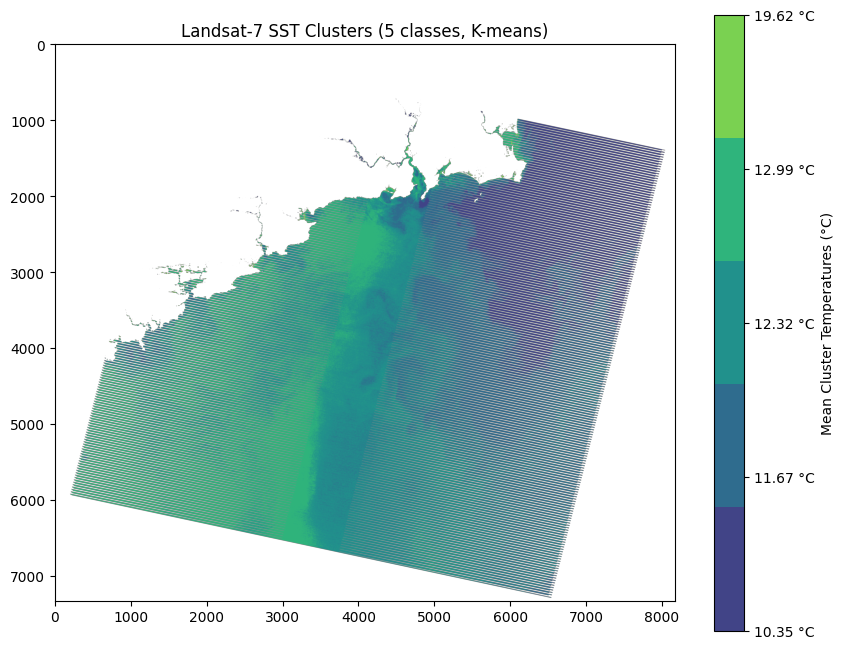

SST cluster plot saved as: ../data/final_plots/sst_clusters_plot.png


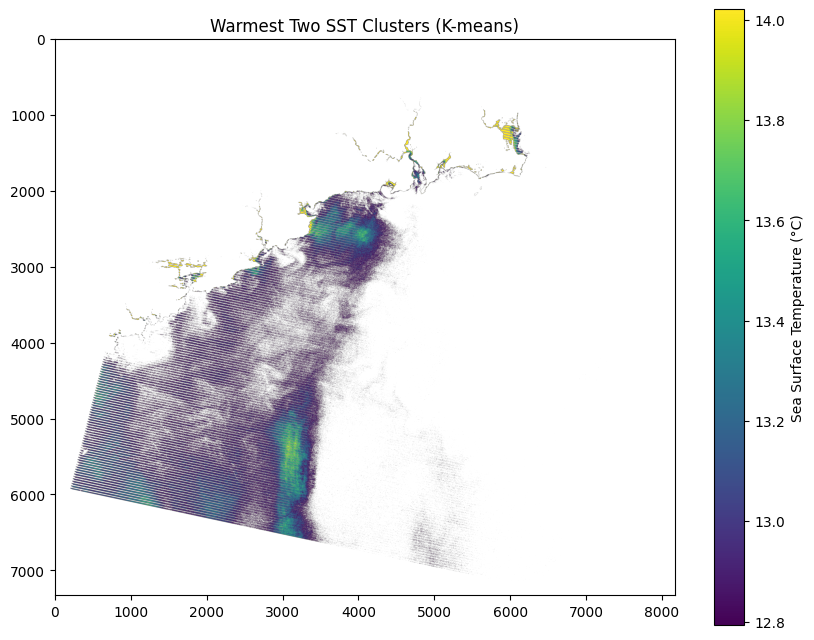

Warmest SST clusters plot saved as: ../data/final_plots/warmest_sst_clusters_plot.png


In [109]:
### Plotting our results

### 11. Plot all clusters from Ckmeans
plt.figure(figsize=(10, 8))
im = plt.imshow(clusters_img, cmap=cmap, vmin=0, vmax=k-1)
cbar = plt.colorbar(im, ticks=range(k))
cbar.ax.set_yticklabels([f"{mean_temps[i]:.2f} °C" for i in sorted_idx])
cbar.set_label("Mean Cluster Temperatures (°C)")
plt.title("Landsat-7 SST Clusters (5 classes, K-means)")

cluster_plot_path = os.path.join(output_dir, "sst_clusters_plot.png")
plt.savefig(cluster_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"SST cluster plot saved as: {cluster_plot_path}")

### 12. Plot 2 warmest clusters
plt.figure(figsize=(10, 8))
vmin, vmax = np.nanpercentile(filtered_sst, [2, 98])
plt.imshow(filtered_sst, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar(label="Sea Surface Temperature (°C)")
plt.title("Warmest Two SST Clusters (K-means)")

filtered_plot_path = os.path.join(output_dir, "warmest_sst_clusters_plot.png")
plt.savefig(filtered_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Warmest SST clusters plot saved as: {filtered_plot_path}")

## References

D'elia, C.F., Webb, K.L. and Porter, J.W., 1981. Nitrate-rich groundwater inputs to Discovery Bay, Jamaica: a significant source of N to local coral reefs?. Bulletin of Marine Science, 31(4), pp.903-910.

Santos, I.R., Chen, X., Lecher, A.L., Sawyer, A.H., Moosdorf, N., Rodellas, V., Tamborski, J., Cho, H.M., Dimova, N., Sugimoto, R. and Bonaglia, S., 2021. Submarine groundwater discharge impacts on coastal nutrient biogeochemistry. Nature Reviews Earth & Environment, 2(5), pp.307-323.

Post, V.E., Groen, J., Kooi, H., Person, M., Ge, S. and Edmunds, W.M., 2013. Offshore fresh groundwater reserves as a global phenomenon. Nature, 504(7478), pp.71-78.

Burnett, W.C., Aggarwal, P.K., Aureli, A., Bokuniewicz, H., Cable, J.E., Charette, M.A., Kontar, E., Krupa, S., Kulkarni, K.M., Loveless, A. and Moore, W.S., 2006. Quantifying submarine groundwater discharge in the coastal zone via multiple methods. Science of the total Environment, 367(2-3), pp.498-543.

Caineta, J., Thomas, B.F. and Bain, D.J., 2022. Submarine groundwater discharge detection through remote sensing: An application of Landsat 7 and 8 in Hawaiʻi and Ireland. Remote Sensing of Environment, 279, p.113109.

Wang, H. and Song, M., 2011. Ckmeans. 1d. dp: optimal k-means clustering in one dimension by dynamic programming. The R journal, 3(2), p.29.

## Sources

https://www.usgs.gov/landsat-missions/landsat-7
https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data
https://www.usgs.gov/faqs/why-do-landsat-7-level-1-products-contain-two-thermal-bands

In [110]:
# ### Plotting our results

# # Plot Brightness Temperature (bt_celsius)
# plt.figure(figsize=(10, 8))
# vmin, vmax = np.nanpercentile(bt_celsius, [2, 98])  # for good contrast; adjust if needed
# im = plt.imshow(bt_celsius, cmap="inferno", vmin=vmin, vmax=vmax)
# bt_plot_path = os.path.join(output_dir, "bt_celsius_plot.png")
# plt.savefig(bt_plot_path, dpi=300, bbox_inches='tight')
# plt.show()


# ### 11. Plot all clusters from Ckmeans
# plt.figure(figsize=(10, 8))
# im = plt.imshow(clusters_img, cmap=cmap, vmin=0, vmax=k-1)


# cluster_plot_path = os.path.join(output_dir, "sst_clusters_plot.png")
# plt.savefig(cluster_plot_path, dpi=300, bbox_inches='tight')
# plt.show()
# print(f"SST cluster plot saved as: {cluster_plot_path}")

# ### 12. Plot 2 warmest clusters
# plt.figure(figsize=(10, 8))
# vmin, vmax = np.nanpercentile(filtered_sst, [2, 98])
# plt.imshow(filtered_sst, cmap="viridis", vmin=vmin, vmax=vmax)

# filtered_plot_path = os.path.join(output_dir, "warmest_sst_clusters_plot.png")
# plt.savefig(filtered_plot_path, dpi=300, bbox_inches='tight')
# plt.show()
# print(f"Warmest SST clusters plot saved as: {filtered_plot_path}")

<!-- ## Environmental Cost

The environmental cost of this project comes mainly in the form of energy usage. As my code was written on a jupyter notebook locally on my computer, these are the main costs:

1. energy usage by PC to run code - ~0.12 kWh
2. energy usage of hosting files on GitHub repo
3. energy usage through internet searches - 

All these activities have a very low energy usage. The energy cost of my local PC is also dependent on the source of the electricity used to charge my laptop (renewable or fossil fuels). My provider EDF energy published their energy mix most recently for April 2023 to March 2024. In this report 20% of their energy was said to come from renewable sources. 

One way to make this more reliable would have been to use the Google Colaboratory could computing environment. While google does not yet produce net-zero emissions (aiming for this by 2030), they have been carbon neutral since 2007 through renewable energy and carbon credit purchases. Since 2017 they have matched their energy usage with investment in renewable energy. While this seems on the surface to be a better solution to running code locally on my laptop, we would also need to consider the energy cost of me using my PC to access the internet to access Google Colab, and the energy cost of my internet use to download and upload files from the USGS and to my google drive.

Overall, my project does not have a direct impact on sustainability or reducing CO2 emissions. However, the relatively very low energy cost justifies it. 

Sources:
https://www.edfenergy.com/fuel-mix
https://blog.google/outreach-initiatives/sustainability/our-third-decade-climate-action-realizing-carbon-free-future/ -->